In [31]:
import os
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

Num GPUs Available:  1
['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


In [32]:
seed = 0
random.seed(seed)
np.random.seed(seed)


class LogisticPolicyAgent:
    
    def __init__(self, theta, alpha, gamma):
        # Init parameters
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def logisticFunc(self, x):
        # Calculate logistic function
        return 1/(1+np.exp(-x))

    def probs(self, state):
        # Return probs for the different actions given a state and theta
        y = np.dot(self.theta, state)
        prob0 = self.logisticFunc(y)
        return np.array([prob0, 1-prob0]) # first element corresponds to taking action 0 (move left), second element action 1 (moving right)

    def gradlog(self, state):
        # Calculate the gradient of log-probs
        y = np.dot(self.theta, state)
        prob0 = self.logisticFunc(y)
        return np.array([state - state*prob0, -state*prob0]) 

    def act(self, state):
        # Return an action given probs
        probs = self.probs(state)
        action = np.random.choice((0, 1), p = probs)
        return action
    '''
    def update(self, rewards, observations, actions):
        # update the theta parameter vector
        G = 0
        for t in reversed(range(len(rewards))):
            G = G * self.gamma + rewards[t]
            gradlog = self.gradlog(observations[t])[actions[t]]
            self.theta += self.alpha + np.power(self.gamma, t) * gradlog * G
    '''
    
    def update(self, rewards, observations, actions):
        # Calculate discounted rewards
        discountedRewards = np.zeros(len(rewards))
        cumRewards = 0
        for t in reversed(range(len(rewards))):
            cumRewards = cumRewards * self.gamma + rewards[t]
            discountedRewards[t] = cumRewards
            
        # Calculate the gradlog for all observations 
        gradlog_all = np.zeros([len(observations), len(self.theta)])
        t=0
        for ob, action in zip(observations, actions):
            gradlog_all[t] = self.gradlog(ob)[action]
            t += 1
            
        # Update theta
        updateVals = np.dot(gradlog_all.T, discountedRewards)
        self.theta += self.alpha * updateVals
    
def run_episode(env, policy):
    
    obs = env.reset()
    totalReward = 0
    observations = []
    actions = []
    rewards= []
    probs = []
    
    done = False
    
    while not done:
        observations.append(obs)
        action = policy.act(obs)
        prob = policy.probs(obs)[action]
        obs, reward, done, info = env.step(action)
        
        totalReward += reward
        actions.append(action)
        rewards.append(reward)
        probs.append(prob)
    
    return totalReward, np.array(observations), np.array(actions), np.array(rewards), np.array(probs)

def train(theta, alpha, gamma, Policy, maxEpisodes):
    
    env = gym.make("CartPole-v1")
    seed = 0
    episodeRewards = []
    policy = Policy(theta, alpha, gamma)
    obslist = []
    actionlist = []
    rewardlist = []
    
    for i in range(maxEpisodes):
        #breakpoint()
        totalReward, observations, actions, rewards, probs = run_episode(env, policy)
        obslist.append(observations)
        actionlist.append(actions)
        rewardlist.append(reward)
        episodeRewards.append(totalReward)
        #print('Updating theta')
        policy.update(rewards, observations, actions)
        obslist = []
        actionlist = []
        rewardlist = []
        print("EPISODE: " + str(i) + ", Score: " + str(totalReward) + ", Theta: " + str(policy.theta))
    
    return episodeRewards, policy

In [33]:
# OBS NEED TO CHANGE SIZE OF THETA VEC TO MATCH OBSERVATION SPACE SIZE
episode_rewards, policy = train(theta=np.random.rand(4),
                                alpha=0.002,
                                gamma=0.99,
                                Policy=LogisticPolicyAgent,
                                maxEpisodes=2000)
episode_rewards = np.array(episode_rewards)


EPISODE: 0, Score: 21.0, Theta: [0.54751838 0.71831812 0.60194346 0.54014806]
EPISODE: 1, Score: 23.0, Theta: [0.54810278 0.72847577 0.60076043 0.5231546 ]
EPISODE: 2, Score: 14.0, Theta: [0.54758547 0.7179129  0.60210728 0.54162686]
EPISODE: 3, Score: 22.0, Theta: [0.54803938 0.72356144 0.60289191 0.53513374]
EPISODE: 4, Score: 29.0, Theta: [0.54561146 0.74739173 0.60362135 0.49817526]
EPISODE: 5, Score: 17.0, Theta: [0.54502568 0.74475912 0.60276857 0.49903401]
EPISODE: 6, Score: 23.0, Theta: [0.54355807 0.74840687 0.60148515 0.490636  ]
EPISODE: 7, Score: 17.0, Theta: [0.54383326 0.75386855 0.60130598 0.48614354]
EPISODE: 8, Score: 35.0, Theta: [0.54772868 0.77915208 0.59664792 0.44641023]
EPISODE: 9, Score: 25.0, Theta: [0.54613139 0.79601203 0.59753123 0.42337699]
EPISODE: 10, Score: 11.0, Theta: [0.54514637 0.78268447 0.59896845 0.44617127]
EPISODE: 11, Score: 26.0, Theta: [0.54676357 0.80634339 0.59716044 0.41271681]
EPISODE: 12, Score: 17.0, Theta: [0.54606761 0.80429612 0.5985

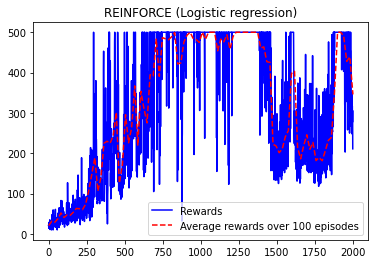

In [34]:
meanRewards = np.mean(episode_rewards.reshape(-1,20), axis=1)
xaxis = np.linspace(1, 2000, 100)
fig, ax = plt.subplots()
ax.plot(episode_rewards, '-b', label='Rewards')
ax.plot(xaxis, meanRewards, '--r', label='Average rewards over 100 episodes')
leg = ax.legend();
plt.title('REINFORCE (Logistic regression)');

In [35]:
# TESTING
env = gym.make('CartPole-v1')


obs = env.reset()
done = False
env.render()
while not done:
    env.render()
    action = policy.act(obs)
    prob = policy.probs(obs)[action]
    obs, reward, done, info = env.step(action)
env.close()